<a href="https://colab.research.google.com/github/suzzini/DS_Project/blob/main/%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C%EB%A6%AC%EB%B7%B0(2)_%EC%98%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 추천 알고리즘 코드 리뷰하기(2)

링크 : https://www.kaggle.com/rounakbanik/movie-recommender-systems

In [1]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 13.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617638 sha256=11480049341e3ce8d53cc49cfe1733ea7fa246e4072bbc2ddf914c81e5536d63
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

evaluate 시 다음과 같이 진행(cross_validate 사용)

```
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the dataset (download it if needed)
data = Dataset.load_builtin('ml-100k')

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
```

### 1. simple recommender system
- 영화의 흥행과 장르에 기반한 간단한 추천시스템
- 대중들에게 좋아요가 높다는 것은 인기와 찬사를 받은 영화라는 것에 기반
- 유저에게 개인화된 맞춤 서비스는 아님

In [3]:
md = pd.read_csv('/content/drive/MyDrive/dataset/movies_metadata.csv/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### IMDB's weighted rating  
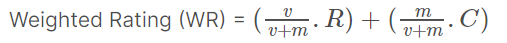






- v is the number of votes for the movie
- m is the minimum votes required to be listed in the chart
- R is the average rating of the movie
- C is the mean vote across the whole report

In [4]:
md['genres']=md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [5]:
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [6]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
m = vote_counts.quantile(0.95) #신빙성을 위해 어느정도의 투표수를 위해 큰 순서대로 95%만 가지고 가기
m

434.0

In [7]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [8]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

- 평가하기 위해 vote_count가 434이상의 이여야 하고
- 그렇게해서 2274개의 영화를 평가하기로 함

In [9]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [10]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [11]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

### Top Movies

In [12]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


### 특정 장르를 위한 함수 생성
- 영화의 genre를 하나로 정의시키기

In [13]:
md.apply(lambda x: pd.Series(x['genres']),axis=1)

,0,1,2,3,4,5,6,7
0,Animation,Comedy,Family,NaN,NaN,NaN,NaN,NaN
1,Adventure,Fantasy,Family,NaN,NaN,NaN,NaN,NaN
2,Romance,Comedy,NaN,NaN,NaN,NaN,NaN,NaN
3,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN
4,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
45461,Drama,Family,NaN,NaN,NaN,NaN,NaN,NaN
45462,Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45463,Action,Drama,Thriller,NaN,NaN,NaN,NaN,NaN
45464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)

0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45461       Family
45462        Drama
45463       Action
45463        Drama
45463     Thriller
Length: 91106, dtype: object

In [15]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [16]:
gen_md

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45463,False,NaN,0,NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,Action
45463,False,NaN,0,NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,Drama
45463,False,NaN,0,NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,Thriller
45464,False,NaN,0,NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,/aorBPO7ak8e8iJKT5OcqYxU3jlK.jpg,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.

vote_count는 95%가 아닌 85%만 가져오기

In [17]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

### Top Romance Movies

In [18]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,8.565285
351,Forrest Gump,1994,8147,8,48.3072,7.971357
876,Vertigo,1958,1162,8,18.2082,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.8451,7.745154
1132,Cinema Paradiso,1988,834,8,14.177,7.744878
19901,Paperman,2012,734,8,7.19863,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.9943,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


### 위와 같은 추천 시스템이 갖는 한계
- 개인화된 추천이 불가능함(모두에게 갖은 영화를 추천)  
- 다른 유저의 정보가 사용되지 않는다

- 특정 매트릭스에 기반하여 영화 간의 연관성(similarity)를 계산하고 유저가 좋아하는 특정 영화와 가장 유사한 영화를 추천할 예정
 
 


### Content Based Filtering이라고 알려진 엔진을 구현하기 위해 movie metadata를 사용
**유저가 관심있는 아이템의 속성을 분석하여** 새로운 아이템을 추천해주는!!

[based on] 
- Movie Overviews and Taglines
- Movie Cast, Crew, Keywords and Genre

In [19]:
pd.read_csv('/content/drive/MyDrive/dataset/movies_metadata.csv/links_small.csv')

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9120,162672,3859980,402672.0
9121,163056,4262980,315011.0
9122,163949,2531318,391698.0
9123,164977,27660,137608.0


In [20]:
links_small = pd.read_csv('/content/drive/MyDrive/dataset/movies_metadata.csv/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small

0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9120    402672
9121    315011
9122    391698
9123    137608
9124    410803
Name: tmdbId, Length: 9112, dtype: int64

In [21]:
#object => int
md['id'] = md['id'].astype('int')

ValueError: ignored

In [22]:
md[md['id']=='1997-08-20']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Midnight Man,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [23]:
md = md.drop([19730, 29503, 35587])

In [24]:
#object => int
md['id'] = md['id'].astype('int')

In [25]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

이렇게 해서 총 9,099개의 영화의 데이터를 얻을 수 있음(약 45,000개의 영화데이터에서 1/5)

### Movie Description Based Recommender
using movie descriptions and taglines

In [26]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [27]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [28]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,A family wedding reignites the ancient feud be...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,Just when George Banks has recovered from his ...


### 벡터화(Vectorize)
컴퓨터는 자연어 자체를 받아들일 수 없습니다. 그래서 컴퓨터가 이해할 수 있도록 벡터로 만들어주어야 합니다.
이 과정을 벡터화(Vectorize)라고 합니다. 자연어를 어떻게 벡터로 표현하는 지는 자연어 처리 모델의 성능을 결정하는 중요한 역할을 합니다.
자연어를 벡터화하는 방법은 크게 2가지로 나누어 볼 수 있습니다.

- 등장 횟수 기반의 단어 표현(Count-based Representation) : 단어가 문서(혹은 문장)에 등장하는 횟수를 기반으로 벡터화하는 방법

  - Bag-of-Words (CounterVectorizer)
  - TF-IDF (TfidfVectorizer)

- TfidfVectorizer 파리미터
  - analyzer : 'word'라고 설정시, 학습의 단위를 단어로 설정합니다. (ex - home, go, my ...)
  - min-df : DF(document-frequency)의 최소 빈도값을 설정해주는 파라미터입니다.
DF는 특정 단어가 나타나는 '문서의 수'를 의미합니다.
단어의 수가 아니라 문서의 수라는 것에 주의
  - ngram_range = (min_n, max_n), min_n 개~ max_n 개를 갖는 n-gram(n개의 연속적인 토큰)을 토큰으로 사용
    - 만약 ngram_range = (1, 2)라고 한다면, 단어의 묶음을 1개부터 2개까지 설정하라는 뜻
    - 단어사전에는 1개 단어묶음도 있고, 2개 단어묶음도 존재하게 되겠죠.
    - 가령, 'go home', 'very good'과 같은 2개 짜리 묶음도 인덱스를 받게 되는 것입니다.

In [29]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [30]:
tfidf_matrix.shape

(9099, 268124)

description 열에 대해서 tf-idf를 수행했습니다. 9,099개의 영화를 표현하기위해 총 268,124개의 단어가 사용되었음을 보여주고 있습니다. 이제 **코사인 유사도**를 사용하면 바로 문서의 유사도를 구할 수 있습니다.

### 코사인 유사도 
코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미합니다. 문서 단어 행렬이나 TF-IDF 행렬을 통해서 문서의 유사도를 구하는 경우에는 문서 단어 행렬이나 TF-IDF 행렬이 각각의 특징 벡터 A, B가 됩니다.

- tf-idf를 할 때 데이터에 Null 값이 들어있으면 에러가 발생(Null 값을 처리하는 도구인 fillna()를 사용)

In [31]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [33]:
smd = smd.reset_index() #인덱스를 나타내는 열 추가
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [34]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
Shin Godzilla                                         9094
The Beatles: Eight Days a Week - The Touring Years    9095
Pokémon: Spell of the Unknown                         9096
Pokémon 4Ever: Celebi - Voice of the Forest           9097
Force Majeure                                         9098
Length: 9099, dtype: int64

In [35]:
def get_recommendations(title):
    # 선택한 영화의 타이틀로부터 해당되는 인덱스를 받아옵니다. 이제 선택한 영화를 가지고 연산할 수 있습니다.
    idx = indices[title]

    # 모든 영화에 대해서 해당 영화와의 유사도를 구합니다.
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 유사도에 따라 영화들을 정렬합니다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 30개의 영화를 받아옵니다.(자기 자신은 제외)
    sim_scores = sim_scores[1:31]

    # 가장 유사한 10개의 영화의 인덱스를 받아옵니다.
    movie_indices = [i[0] for i in sim_scores]

    # 가장 유사한 10개의 영화의 제목을 리턴합니다.
    return titles.iloc[movie_indices]

In [36]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [37]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

### genre, keywords, cast and crew를 고려한 좀 더 정교한 추천시스템 구축하기

In [38]:
credits = pd.read_csv('/content/drive/MyDrive/dataset/movies_metadata.csv/credits.csv/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/dataset/movies_metadata.csv/keywords.csv/keywords.csv')

In [42]:
md.shape

(45463, 25)

In [40]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [43]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [44]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

#### literal_eval 
문자열을 딕셔너리/리스트 형태로 바꿔줌

```
a = "['호랑이', '사자', '기린']"
a = liter_eval(a)
a = ['호랑이', '사자', '기린']
```



In [50]:
smd['keywords']

0        [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1        [{'id': 10090, 'name': 'board game'}, {'id': 1...
2        [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
3        [{'id': 818, 'name': 'based on novel'}, {'id':...
4        [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...
                               ...                        
40952    [{'id': 6054, 'name': 'friendship'}, {'id': 20...
41172                 [{'id': 10540, 'name': 'bollywood'}]
41225                 [{'id': 10540, 'name': 'bollywood'}]
41391    [{'id': 1299, 'name': 'monster'}, {'id': 7671,...
41669    [{'id': 6027, 'name': 'music'}, {'id': 10073, ...
Name: keywords, Length: 9219, dtype: object

In [51]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [53]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7


In [57]:
smd['crew'][0]

[{'credit_id': '52fe4284c3a36847f8024f49',
  'department': 'Directing',
  'gender': 2,
  'id': 7879,
  'job': 'Director',
  'name': 'John Lasseter',
  'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f4f',
  'department': 'Writing',
  'gender': 2,
  'id': 12891,
  'job': 'Screenplay',
  'name': 'Joss Whedon',
  'profile_path': '/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f55',
  'department': 'Writing',
  'gender': 2,
  'id': 7,
  'job': 'Screenplay',
  'name': 'Andrew Stanton',
  'profile_path': '/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f5b',
  'department': 'Writing',
  'gender': 2,
  'id': 12892,
  'job': 'Screenplay',
  'name': 'Joel Cohen',
  'profile_path': '/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f61',
  'department': 'Writing',
  'gender': 0,
  'id': 12893,
  'job': 'Screenplay',
  'name': 'Alec Sokolow',
  'profile_path': '/v79vlRYi94BZUQnkkyzn

In [58]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [59]:
smd['director'] = smd['crew'].apply(get_director)

In [60]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [62]:
smd['keywords'][0]

[{'id': 931, 'name': 'jealousy'},
 {'id': 4290, 'name': 'toy'},
 {'id': 5202, 'name': 'boy'},
 {'id': 6054, 'name': 'friendship'},
 {'id': 9713, 'name': 'friends'},
 {'id': 9823, 'name': 'rivalry'},
 {'id': 165503, 'name': 'boy next door'},
 {'id': 170722, 'name': 'new toy'},
 {'id': 187065, 'name': 'toy comes to life'}]

In [63]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [64]:
smd['keywords'][0]

['jealousy',
 'toy',
 'boy',
 'friendship',
 'friends',
 'rivalry',
 'boy next door',
 'new toy',
 'toy comes to life']

In [65]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [66]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [67]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[johnlasseter, johnlasseter, johnlasseter]"
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,"[joejohnston, joejohnston, joejohnston]"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,"[howarddeutch, howarddeutch, howarddeutch]"
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]"
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,"[charlesshyer, charlesshyer, charlesshyer]"


In [68]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [69]:
s

0           jealousy
0                toy
0                boy
0         friendship
0            friends
            ...     
41391    destruction
41391          kaiju
41391          toyko
41669          music
41669    documentary
Name: keyword, Length: 64407, dtype: object

In [70]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [71]:
s = s[s > 1]

#### SnowballStemmer
어간(Stem)을 추출하는 작업을 어간 추출(stemming)

In [72]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [73]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [74]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [75]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

### CountVectorizer
문서, 문장들에서 문법이나 단어의 순서 등의 개념을 제거하고 단순히 단어들의 빈도만 고려

- stop_words = 'english' 영어에 해당하는 불용어 처리를 합니다.
- max_features=n, 빈도 순서대로 top n 단어만 사용합니다.

1. 문서를 토큰 리스트로 변환한다.

2. 각 문서에서 토큰의 출현 빈도를 센다.

3. 각 문서를 BOW 인코딩 벡터로 변환한다.

In [76]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [83]:
count_matrix

<9219x107377 sparse matrix of type '<class 'numpy.int64'>'
	with 240050 stored elements in Compressed Sparse Row format>

soup 열에 대해서 tf-idf를 수행했습니다. 9,219개의 영화를 표현하기위해 총 107,377개의 단어가 사용되었음을 보여주고 있습니다. 이제 코사인 유사도를 사용하면 바로 문서의 유사도를 구할 수 있습니다.

In [77]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [78]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [82]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
The Last Brickmaker in America                        9214
Rustom                                                9215
Mohenjo Daro                                          9216
Shin Godzilla                                         9217
The Beatles: Eight Days a Week - The Touring Years    9218
Length: 9219, dtype: int64

1. 유사도가 Top 25 & 상위 60%의 vote_count인 영화 추출
2. IMDB's formula를 통해 최종적으로 상위 10개의 영화 출력

In [79]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    #상위 25개의 영화를 대상으로 
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [80]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
1134,Batman Returns,1706,6,1992,5.846862
132,Batman Forever,1529,5,1995,5.054144
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1260,Batman & Robin,1447,4,1997,4.287233


In [81]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

### Collaborative Filtering

**유저-아이템의 관계(User-Item interaction)로부터 도출되는 추천 시스템**

나와 비슷한 유저에게 내가 좋아하는 영화를 추천하면 어떨까?  

### Singular Value Decomposition (SVD) 
to minimise RMSE (Root Mean Square Error)